In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import regularizers
tf.__version__

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from sklearn.model_selection import train_test_split

In [2]:
import scipy
scipy.__version__

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

In [3]:
#!pip install camb

import camb
from camb import model, initialpower

kmin = 1e-4
kmax = 15

(8000, 300)
(8000, 1)
55.000126 84.99784


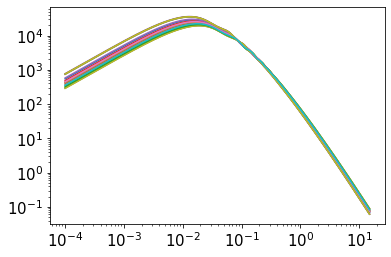

In [4]:
with np.load('../data/input_pk_h0_k300.npy') as data:
    h_lhs = data['H']
    kh = data['k']
    input_pk = data['pk']

print(np.shape(input_pk))
print(np.shape(h_lhs))

for i in range(20):
  plt.loglog(kh, input_pk[i])    

Npoints = len(input_pk[0])  
print(h_lhs.min(), h_lhs.max())

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

xscaler = StandardScaler() #MinMaxScaler()
yscaler = StandardScaler() #MinMaxScaler()

scaled_input = xscaler.fit(h_lhs)
scaled_output = yscaler.fit(input_pk)

norm_x = scaled_input.transform(h_lhs)                               
norm_y = scaled_output.transform(input_pk)

print(norm_x.min(), norm_x.max())

norm_x = pd.DataFrame(norm_x)
norm_y = pd.DataFrame(norm_y)

-1.7320347 1.731803


In [6]:
x_train, x_test, y_train, y_test = train_test_split(norm_x,
                                                    norm_y,
                                                    test_size=0.3,
                                                    random_state=1273)

np.shape(y_test), np.shape(y_train), np.shape(x_test), np.shape(x_train)

((2400, 300), (5600, 300), (2400, 1), (5600, 1))

In [7]:
# Working model

input_dim = x_train.shape[1]
output_dim = Npoints

model_nn = Sequential()
model_nn.add(Dense(units=200, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
#model_nn.add(Dropout(0.2))
model_nn.add(Dense(units=200, kernel_initializer='normal', activation='relu'))
model_nn.add(Dropout(0.1))
model_nn.add(Dense(units=200, kernel_initializer='normal', activation='relu'))
model_nn.add(Dropout(0.1))
model_nn.add(Dense(output_dim, kernel_initializer='normal'))

model_nn.summary()


initial_learning_rate = 7e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.1,
    staircase=True)

#model_nn.compile(loss="mae")
model_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.007),
                 loss="mean_squared_error")
                 #loss=tf.keras.losses.MeanSquaredLogarithmicError())
                 #loss="kl_divergence")
history_nn = model_nn.fit(x_train, y_train, batch_size=100, epochs=250, verbose=0, validation_split=0.3) #validation_data=(x_test, y_test))

2022-06-18 06:28:01.995959: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-18 06:28:01.996679: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-18 06:28:01.998646: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-06-18 06:28:02.134437: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-18 06:28:02.157750: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300800000 Hz


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               60300     
Total params: 141,100
Trainable params: 141,100
Non-trainable params: 0
__________________________________________________

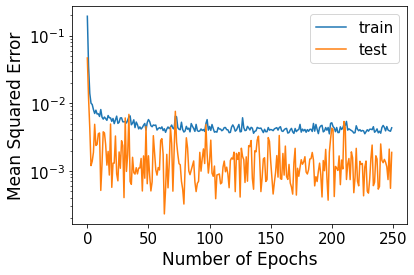

In [8]:
plt.plot(history_nn.history["loss"], label="train")
plt.plot(history_nn.history["val_loss"], label="test")
#plt.xlim([0, 500])
#plt.ylim([0, 0.15])
plt.xlabel("Number of Epochs", fontsize=17)
plt.ylabel("Mean Squared Error", fontsize=17)
plt.yscale("log")
plt.legend(fontsize=15)

In [25]:
s8_fid = 0.8129

HH0 = 71.3
new_H0 = np.reshape(np.array(HH0),(1, 1))
#scaled = xscaler.fit(h_lhs)
#input_scaled = scaled.transform(new_H0/100.0)
new_h = new_H0
input_scaled = scaled_input.transform(new_h)
print(input_scaled)
predicted_pk = scaled_output.inverse_transform(model_nn.predict([input_scaled]))

pars = camb.CAMBparams()
pars.set_cosmology(H0=HH0, ombh2=0.02242, omch2=0.11933)
pars.InitPower.set_params(As=2.105209331e-9, ns=0.9665)
pars.set_matter_power(redshifts=[0.0], kmax=15.0)
pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

# Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, un_pk = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints=Npoints)
s8_camb = np.array(results.get_sigma8())
Renorm_Factor = s8_fid**2/s8_camb**2
output_pk_compare = Renorm_Factor * un_pk

[[0.15011256]]


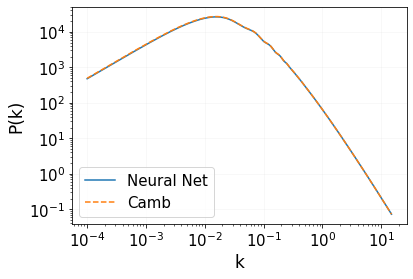

In [26]:
plt.loglog(kh, predicted_pk[0], "C0-", label="Neural Net")
plt.loglog(kh, output_pk_compare[0], "C1--", label="Camb")
plt.ylabel("P(k)", fontsize=17)
plt.xlabel("k", fontsize=17)
#plt.loglog(kh, output_pk_compare_1[0], "C2-.")
plt.legend(fontsize=15)
plt.grid(alpha=0.1)

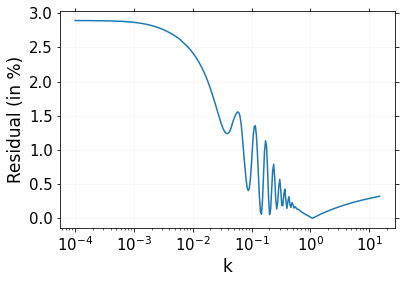

In [27]:
plt.plot(kh, np.abs((predicted_pk[0]-output_pk_compare[0])/output_pk_compare[0])*100)
#plt.plot(kh, np.abs((output_pk_compare_1[0]-output_pk_compare[0])/output_pk_compare[0])*100)
plt.xscale("log")
plt.ylabel("Residual (in %)", fontsize=17)
plt.xlabel("k", fontsize=17)
plt.grid(alpha=0.1)
plt.tick_params(top=True, right=True)

# ICA - Dimensionality reduction

In [12]:
from sklearn.decomposition import FastICA

Ncomponents = 5

transformer = FastICA(n_components=Ncomponents,
                        random_state=0,
                        max_iter=10000)

pk_transformed = transformer.fit_transform(input_pk)

yica_scaler = StandardScaler() #MinMaxScaler()

ica_scaled_output = yica_scaler.fit(pk_transformed)
                              
norm_ica_y = ica_scaled_output.transform(pk_transformed)
print(norm_ica_y.min(), norm_ica_y.max())

norm_ica_y = pd.DataFrame(norm_ica_y)

-5.168998519157864 1.7102263734165941


In [13]:
x_ica_train, x_ica_test, y_ica_train, y_ica_test = train_test_split(norm_x,
                                                                    norm_ica_y,
                                                                    test_size=0.2,
                                                                    random_state=1273)

print(np.shape(y_ica_test), np.shape(y_ica_train), np.shape(x_ica_test), np.shape(x_ica_train))


input_ica_dim = x_ica_train.shape[1]
output_ica_dim = Ncomponents

print(input_ica_dim, output_ica_dim)

(1600, 5) (6400, 5) (1600, 1) (6400, 1)
1 5


In [14]:
model_ica_nn = Sequential()
model_ica_nn.add(Dense(units=200, input_dim=input_ica_dim, kernel_initializer='normal', activation='relu'))
model_ica_nn.add(Dense(units=200, kernel_initializer='normal', activation='relu'))
model_ica_nn.add(Dropout(0.1))
model_ica_nn.add(Dense(units=200, kernel_initializer='normal', activation='relu'))
model_ica_nn.add(Dropout(0.1))
model_ica_nn.add(Dense(output_ica_dim, kernel_initializer='normal'))

model_ica_nn.summary()

initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.1,
    staircase=True)


model_ica_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),#1e-3),
                 loss="mean_squared_error",
                 metrics="Accuracy")
history_ica_nn = model_ica_nn.fit(x_ica_train, y_ica_train, batch_size=100, epochs=250, verbose=0, validation_split=0.3) #validation_data=(x_test, y_test))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 200)               400       
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 1005      
Total params: 81,805
Trainable params: 81,805
Non-trainable params: 0
__________________________________________________

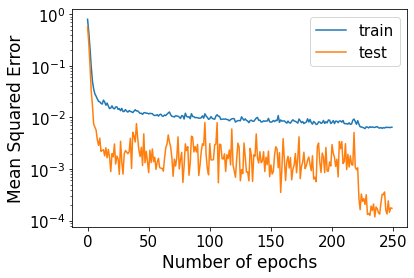

In [15]:
plt.plot(history_ica_nn.history["loss"], label="train")
plt.plot(history_ica_nn.history["val_loss"], label="test")
#plt.xlim([0, 500])
#plt.ylim([0, 0.15])
plt.xlabel("Number of epochs", fontsize=17)
#plt.ylabel("mean absolute error")
plt.ylabel("Mean Squared Error", fontsize=17)
plt.yscale("log")
plt.legend(fontsize=15)

In [22]:
s8_fid = 0.8129

HH0 = 71.3
new_H0 = np.reshape(np.array(HH0),(1, 1))
#scaled = xscaler.fit(h_lhs)
#input_scaled = scaled.transform(new_H0/100.0)
new_h = new_H0
input_scaled = scaled_input.transform(new_h)
print(input_scaled)
predicted_pk = ica_scaled_output.inverse_transform(model_ica_nn.predict([input_scaled]))
inverse_pk = transformer.inverse_transform(predicted_pk)

pars = camb.CAMBparams()
pars.set_cosmology(H0=HH0, ombh2=0.02242, omch2=0.11933)
pars.InitPower.set_params(As=2.105209331e-9, ns=0.9665)
pars.set_matter_power(redshifts=[0.0], kmax=15.0)
pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

# Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, un_pk = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints=Npoints)
s8_camb = np.array(results.get_sigma8())
Renorm_Factor = s8_fid**2/s8_camb**2
output_pk_compare_ica = Renorm_Factor * un_pk

[[0.15011256]]


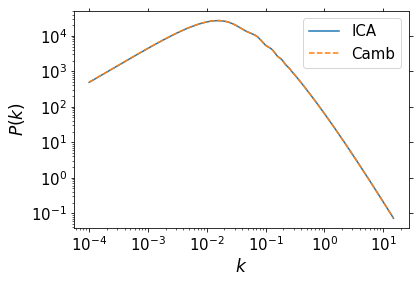

In [23]:
plt.loglog(kh, inverse_pk[0], "C0-", label="ICA")
plt.loglog(kh, output_pk_compare_ica[0], "C1--", label="Camb")
plt.ylabel("$P(k)$", fontsize=17)
plt.xlabel("$k$", fontsize=17)
plt.legend(fontsize=15)
plt.tick_params(top=True, right=True)

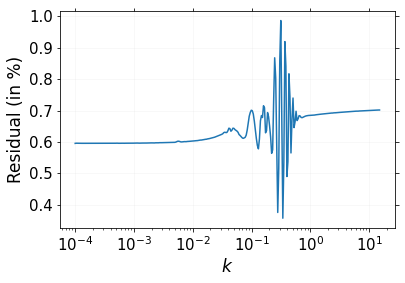

In [24]:
plt.plot(kh, np.abs((inverse_pk[0]-output_pk_compare_ica[0])/output_pk_compare_ica[0])*100)
plt.xscale("log")
plt.grid(alpha=0.1)
plt.ylabel("Residual (in %)", fontsize=17)
plt.xlabel("$k$", fontsize=17)
plt.tick_params(top=True, right=True)